In [89]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["WANDB_DISABLED"] = "true"

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
from datasets import Dataset
import datetime

In [ ]:
from transformers import (
    BertTokenizerFast,
    BertConfig,
    BertForMaskedLM,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer
)

### Data

In [91]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:

events_df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/events.csv')


### Events DataFrame Exploration

In [93]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


Transactionid happens only when user made a purchase

In [94]:
events_df.loc[events_df['transactionid'].notnull()]['event'].unique()

array(['transaction'], dtype=object)

Transaction id is null means user has either viewed or added the product to cart

In [95]:
events_df.loc[events_df['transactionid'].isna()]['event'].unique()

array(['view', 'addtocart'], dtype=object)

We have 1.4M unique customers, total users, incuding someone who purchased anything or just casually browsed through the products

In [8]:
events_df['visitorid'].nunique()

1407580

We have around 11k unique customers who purchased something in our dataset. We have a lot of casual shoppers which can add a lot of noise in our recommendation system

In [9]:
print("Number of customers who purchased:", events_df.loc[events_df['transactionid'].notnull()]['visitorid'].nunique())

Number of customers who purchased: 11719


In [10]:
customers_purchased_df= events_df.loc[events_df['transactionid'].notnull()]

In [11]:
customers_purchased_df

,timestamp,visitorid,event,itemid,transactionid
130,1433222276276,599528,transaction,356475,4000.0
304,1433193500981,121688,transaction,15335,11117.0
418,1433193915008,552148,transaction,81345,5444.0
814,1433176736375,102019,transaction,150318,13556.0
843,1433174518180,189384,transaction,310791,7244.0
...,...,...,...,...,...
2755294,1438377176570,1050575,transaction,31640,8354.0
2755349,1438379878779,861299,transaction,456602,3643.0
2755508,1438357730123,855941,transaction,235771,4385.0
2755603,1438355560300,548772,transaction,29167,13872.0


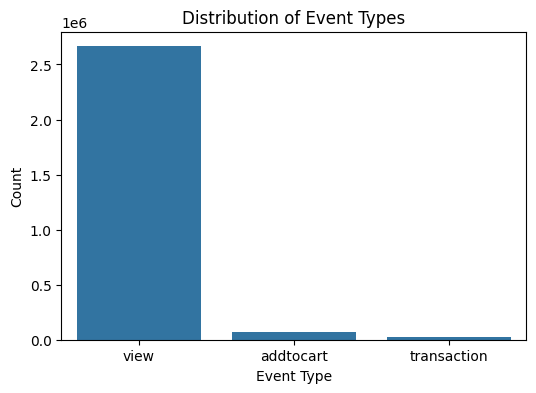

In [96]:


event_counts = events_df['event'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=event_counts.index, y=event_counts.values)
plt.title("Distribution of Event Types")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()

Snapshot of a visitor and it's buying's journey from viewing to adding to cart

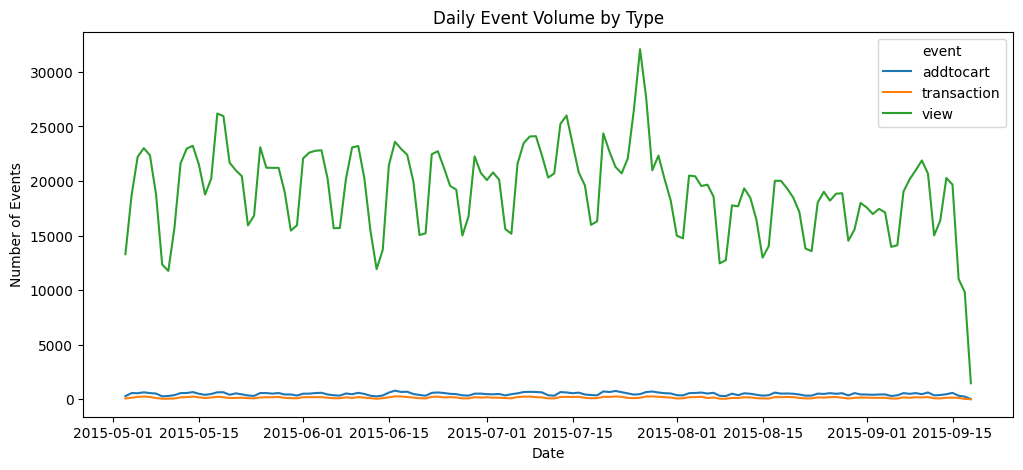

In [97]:
events_df['timestamp'] = pd.to_datetime(events_df['timestamp'], unit='ms')
events_df['date'] = events_df['timestamp'].dt.date

daily_events = events_df.groupby(['date', 'event']).size().unstack().fillna(0)

daily_events.plot(figsize=(12, 5))
plt.title("Daily Event Volume by Type")
plt.xlabel("Date")
plt.ylabel("Number of Events")
plt.show()

In [12]:
events_df[events_df['visitorid']==6].sort_values('timestamp')

,timestamp,visitorid,event,itemid,transactionid
1133190,1440914628202,6,addtocart,65273,NaN
1135980,1440916778318,6,view,253615,NaN
1130136,1440916823805,6,view,344723,NaN
1130169,1440917649385,6,view,344723,NaN
1143479,1440917793838,6,view,344723,NaN
1137104,1440991285697,6,view,344723,NaN


In [17]:

times =[]
for i in events_df['timestamp']:
    times.append(datetime.datetime.fromtimestamp(i//1000.0))

In [18]:
events_df['formatted_datetime']=times
events_df['formatted_date']= events_df['formatted_datetime'].dt.date

In [19]:


unique_items = events_df["itemid"].unique()
print("Number of unique items:", len(unique_items))

Number of unique items: 235061


Creating list of itemid based on user based sessions for one day

In [23]:
sequences_df = (
    events_df
    .groupby(['visitorid', 'formatted_date'])['itemid']
    .agg(list)
    .reset_index()
    .rename(columns={'itemid': 'itemid_sequence'})
)


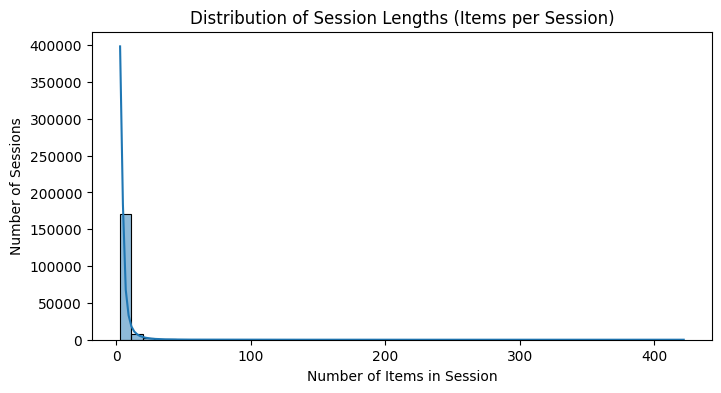

In [100]:


sequences_df["sequence_length"] = sequences_df["itemid_sequence"].apply(len)

plt.figure(figsize=(8, 4))
sns.histplot(sequences_df["sequence_length"], bins=50, kde=True)
plt.title("Distribution of Session Lengths (Items per Session)")
plt.xlabel("Number of Items in Session")
plt.ylabel("Number of Sessions")
plt.show()

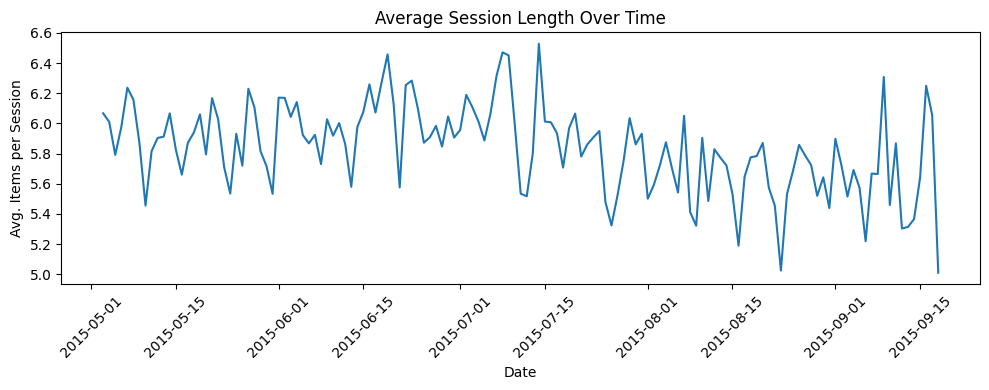

In [101]:
session_length_by_day = (
    sequences_df.groupby("formatted_date")["sequence_length"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 4))
sns.lineplot(data=session_length_by_day, x="formatted_date", y="sequence_length")
plt.title("Average Session Length Over Time")
plt.xlabel("Date")
plt.ylabel("Avg. Items per Session")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Filtering Sessions by Sequence Length

To ensure meaningful sequential patterns in our model training, we filter out sessions that contain fewer than 3 item interactions.

Sessions with only 1 or 2 items typically lack sufficient context for a transformer-based model like BERT to learn positional relationships and masked token dependencies effectively.

We retain only sessions where:

- The user interacted with **at least 3 items** during a single day
- These longer sequences help the model learn transitions, co-occurrence patterns, and contextual dependencies between items

This filtering step helps improve training stability and model performance by ensuring each input sequence provides enough signal for the model to learn from.

In [24]:
sequences_df["seq_len"]= sequences_df['itemid_sequence'].apply(lambda x: len(x))
sequences_df=sequences_df[sequences_df["seq_len"]>=3]

In [26]:
sequences_df['itemid_text'] = sequences_df['itemid_sequence'].apply(
    lambda seq: ' '.join(map(str, seq))
)

In [28]:
sequences_df['seq_len'].describe()

,seq_len
count,183259.000000
mean,5.863428
std,8.995744
min,3.000000
25%,3.000000
50%,4.000000
75%,6.000000
max,422.000000


### Building a Custom Tokenizer

We create a tokenizer using `BertTokenizerFast` with a custom vocabulary of unique item IDs.

Special tokens like `[PAD]`, `[MASK]`, etc., are included. This lets us convert user sessions into sequences suitable for BERT-style modeling.


In [ ]:
# Reserve 0 for [PAD], 1 for [UNK], then start real items at 2
PAD_TOKEN = 0
UNK_TOKEN = 1

unique_items = sorted(unique_items)
item2idx = {}

# Initialize with special tokens
item2idx["[PAD]"] = PAD_TOKEN
item2idx["[UNK]"] = UNK_TOKEN

idx_offset = 2
for i, item_id in enumerate(unique_items, start=idx_offset):
    item2idx[str(item_id)] = (i)

In [29]:


vocab_file = "custom_vocab.txt"
with open(vocab_file, "w", encoding="utf-8") as f:
    for token in item2idx:
        f.write(token + "\n")

# ----- Load the custom vocabulary with BertTokenizerFast -----
tokenizer = BertTokenizerFast(vocab_file=vocab_file, do_lower_case=False)

# Saving the tokenizer for future use:
tokenizer.save_pretrained("./custom_tokenizer")

('./custom_tokenizer/tokenizer_config.json',
 './custom_tokenizer/special_tokens_map.json',
 './custom_tokenizer/vocab.txt',
 './custom_tokenizer/added_tokens.json',
 './custom_tokenizer/tokenizer.json')

In [31]:

hf_dataset = Dataset.from_pandas(sequences_df[['itemid_text']])

In [33]:
# Spliting into train/test
split_dataset = hf_dataset.train_test_split(test_size=0.1, seed=42)
dataset_dict = DatasetDict({
    "train": split_dataset["train"],
    "test": split_dataset["test"]
})

In [34]:
def tokenize_function(examples):

    return tokenizer(
        examples["itemid_text"],
        padding="max_length",
        truncation=True,
        max_length=12
    )

tokenized_dataset = dataset_dict.map(tokenize_function, batched=True)

Map:   0%|          | 0/164933 [00:00<?, ? examples/s]

Map:   0%|          | 0/18326 [00:00<?, ? examples/s]

In [35]:
# Inspecting the first example
print(tokenized_dataset['train'][0])

{'itemid_text': '30602 308524 30602', '__index_level_0__': 467770, 'input_ids': [235064, 15455, 155408, 15455, 235063, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [36]:
# MLM data collator for dynamic masking
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###  Initializing a Custom BERT Model

We define a `BertForMaskedLM` model from scratch using a config that matches our custom vocab size and a lightweight architecture.

This allows the model to learn item-to-item transitions in session-based sequences.

In [102]:
checkpoint_dir = "/content/drive/MyDrive/Colab Notebooks/checkpoints"

In [40]:
config = BertConfig(
    vocab_size=235066,
    hidden_size=128,
    num_hidden_layers=2,
    num_attention_heads=4,
    intermediate_size=256,
    max_position_embeddings=64,
    type_vocab_size=1
)

In [41]:
model = BertForMaskedLM(config)
model.cpu()
model.to("cuda")

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(235066, 128, padding_idx=0)
      (position_embeddings): Embedding(64, 128)
      (token_type_embeddings): Embedding(1, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise

In [ ]:
training_args = TrainingArguments(
    output_dir=checkpoint_dir,
    num_train_epochs=20,
    per_device_train_batch_size=32,
    save_strategy="steps",
    logging_steps=100,
    save_steps=1000,
    evaluation_strategy="epoch",
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator
)

# Train
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,10.459800,nan
2,10.064100,nan
3,9.514800,nan
4,9.126900,nan
5,8.747100,nan
6,8.315000,nan
7,8.025200,nan


In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Resuming Training from Checkpoint

We save checkpoints regularly to Google Drive.

If training is interrupted, we reload the latest checkpoint and resume using `resume_from_checkpoint=checkpoint_dir`.

In [50]:


model = BertForMaskedLM.from_pretrained(checkpoint_dir)
model.cpu()
model.to("cuda")


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(235066, 128, padding_idx=0)
      (position_embeddings): Embedding(64, 128)
      (token_type_embeddings): Embedding(1, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise

In [52]:
training_args = TrainingArguments(
    output_dir=checkpoint_dir,
    num_train_epochs=20,
    per_device_train_batch_size=32,
    save_strategy="steps",
    logging_steps=100,
    save_steps=1000,
    evaluation_strategy="epoch",
)

#  Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator
)

#  Train
trainer.train(resume_from_checkpoint=checkpoint_dir)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].


Epoch,Training Loss,Validation Loss
8,7.643900,nan
9,7.494600,nan
10,7.065400,nan
11,6.939800,nan
12,6.921200,nan
13,6.712200,nan
14,6.539400,nan
15,6.489300,nan
16,6.284900,nan
17,6.149700,nan


TrainOutput(global_step=103100, training_loss=4.15980898423292, metrics={'train_runtime': 8251.9494, 'train_samples_per_second': 399.743, 'train_steps_per_second': 12.494, 'total_flos': 163734926688000.0, 'train_loss': 4.15980898423292, 'epoch': 20.0})

In [57]:
trainer.save_model("/content/drive/MyDrive/contextrec_model")
tokenizer.save_pretrained("/content/drive/MyDrive/contextrec_model")

('/content/drive/MyDrive/contextrec_model/tokenizer_config.json',
 '/content/drive/MyDrive/contextrec_model/special_tokens_map.json',
 '/content/drive/MyDrive/contextrec_model/vocab.txt',
 '/content/drive/MyDrive/contextrec_model/added_tokens.json',
 '/content/drive/MyDrive/contextrec_model/tokenizer.json')

### Evaluation

We mask one item per test sequence and check if the true item appears in the model's top-K predictions.

Recall@K shows how well the model retrieves relevant items based on session context.

In [58]:
model = BertForMaskedLM.from_pretrained("/content/drive/MyDrive/contextrec_model")
tokenizer = BertTokenizerFast.from_pretrained("/content/drive/MyDrive/contextrec_model")

In [59]:
model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(235066, 128, padding_idx=0)
      (position_embeddings): Embedding(64, 128)
      (token_type_embeddings): Embedding(1, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise

In [80]:
def evaluate_top_k_accuracy(dataset, top_k=5, max_examples=1000):
    top1_correct = 0
    topk_correct = 0
    total = 0

    for example in tqdm(dataset.select(range(min(len(dataset), max_examples)))):
        input_ids = torch.tensor(example["input_ids"])
        non_pad_positions = [i for i, tid in enumerate(input_ids) if tid not in [tokenizer.pad_token_id]]

        # Skip short or empty sequences
        if len(non_pad_positions) < 2:
            continue

        mask_pos = non_pad_positions[len(non_pad_positions) // 2]  # middle item
        original_token_id = input_ids[mask_pos].item()

        # Mask the token
        masked_input_ids = input_ids.clone()
        masked_input_ids[mask_pos] = tokenizer.mask_token_id
        masked_input_ids = masked_input_ids.unsqueeze(0).to(model.device)

        with torch.no_grad():
            outputs = model(masked_input_ids)
            logits = outputs.logits[0, mask_pos]

        topk = torch.topk(logits, top_k).indices.tolist()

        if original_token_id == topk[0]:
            top1_correct += 1
        if original_token_id in topk:
            topk_correct += 1
        total += 1

    print(f"\nEvaluated on {total} sequences")
    print(f"Top-1 Accuracy: {top1_correct / total:.4f}")
    print(f"Top-{top_k} Accuracy: {topk_correct / total:.4f}")

In [85]:
evaluate_top_k_accuracy(tokenized_dataset["test"], top_k=50, max_examples=5000)

100%|██████████| 5000/5000 [00:32<00:00, 153.94it/s]


Evaluated on 5000 sequences
Top-1 Accuracy: 0.2670
Top-50 Accuracy: 0.5062


In [86]:
def recall_at_k(dataset, model, tokenizer, k=5, max_examples=1000):
    model.eval()
    total = 0
    hit_count = 0

    for example in tqdm(dataset.select(range(min(len(dataset), max_examples)))):
        input_ids = torch.tensor(example["input_ids"])

        # Skip sequences with only padding
        non_pad_positions = [i for i, tid in enumerate(input_ids) if tid != tokenizer.pad_token_id]
        if len(non_pad_positions) < 2:
            continue

        # Choose a position to mask (e.g., middle)
        mask_pos = non_pad_positions[len(non_pad_positions) // 2]
        true_token_id = input_ids[mask_pos].item()

        # Mask it
        masked_input_ids = input_ids.clone()
        masked_input_ids[mask_pos] = tokenizer.mask_token_id
        masked_input_ids = masked_input_ids.unsqueeze(0).to(model.device)

        with torch.no_grad():
            logits = model(masked_input_ids).logits[0, mask_pos]
            topk_ids = torch.topk(logits, k).indices.tolist()

        if true_token_id in topk_ids:
            hit_count += 1
        total += 1

    recall = hit_count / total if total > 0 else 0
    print(f"Recall@{k}: {recall:.4f} over {total} samples")
    return recall

In [87]:
recall_at_k(
    dataset=tokenized_dataset["test"],
    model=model,
    tokenizer=tokenizer,
    k=5,
    max_examples=1000  # adjust based on your dataset size
)


100%|██████████| 1000/1000 [00:07<00:00, 125.54it/s]

Recall@5: 0.3690 over 1000 samples


0.369